<a href="https://colab.research.google.com/github/aleksejalex/DetermiTime/blob/main/NAEX_Gaj_determinants_COLAB_VERSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "DetermiTime"
(determinant + time)

*by Aleksej Gaj*

**Experiment performed:** time needed to compute a determinant of a matrix is of interest.
Variables considered - see table below.

Both data generation (scripts in repo) and analysis (below) were performed in Python 3.12.

This notebook presents **factorial analysis** of the experiment.


*Note: the table is wide, ie. it can be visualised properly on high DPI monitor (or zoomed out browser).*

## Data generation

Dataset was generated via python program (in repo) run on 3 laptops. Resulting datasets were saved and merged together. This notebook imports already merged dataset.

### Algorithm of generating data

Aim of this experiment is to determine which properties of matrix affect amount of time needed for computation of determinant of the matrix.

Data were generated using `measure_script.py`, where are simply several for cycles inside each other (which ensures running det(mtx) for every combination of parameters mentioned above).
Besides named parameters also many other technical details are set (CPU type, OS, kernel version, current time, etc.)

Resulting dataframe is saved as csv file, which is loaded in this notebook.

### Random order of experiments

The design itself was not randomised in every variable:
 - to eliminate influence of the order in which measurements were performed, Python kernel **was given a brake after every sequence of measurements** (time.sleep(5)). Also as one of variables considered `sleep`was taken, which was 0sek or 0.3sek between every computation.
 - Set of experiments was performed on **3 different laptops independently in randomly chosen order** (ie. `num_of_cores` is randomized by design).
 - All machines had **plenty of RAM available** for Python kernel, so the dependency on that was eliminated too (for instance cases like: big matrix can allocate more RAM and run faster then smaller matrix).
 - **wear of machines** can be considered as not significant due to very short computing time.

### Deep theoretical background:

 - method from LAPACK used by `scipy.linalg.det()` *(USED HERE)* >>
https://netlib.org/lapack/explore-html/db/d04/group__getrf.html

 - method from LAPACK used by `numpy.linalg.det()` *(NOT TESTED HERE)* >>
https://netlib.org/lapack/explore-html/db/d04/group__getrf_gaea332d65e208d833716b405ea2a1ab69.html \
Had problems with higher dimensions and problems with almost-singular matrices.

## imports

In [3]:
!python3 --version

Python 3.10.12


In [20]:
!mkdir img

In [4]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

## loading and PREPARING dataset (LONG CODE), without center points

In [5]:
#file_path = 'df_raw_1.csv' # first run, no centepoints available
#file_path = 'df_raw.csv'  # second run, no centerpoints (c-p filtered)
#file_path_with_centerpoints = 'df_raw_centerpoints.csv'  # second run, including centerpoints

file_path = 'https://raw.githubusercontent.com/aleksejalex/DetermiTime/main/df_raw.csv'  # second run, no centerpoints (c-p filtered)
file_path_with_centerpoints = 'https://raw.githubusercontent.com/aleksejalex/DetermiTime/main/df_raw_centerpoints.csv'  # second run, including centerpoints

#file_path_to_pickle = 'df_raw.pkl'

# Load the DataFrame
try:
    #df_raw = pd.read_pickle(file_path_to_pickle)
    df_raw = pd.read_csv(file_path, delimiter=';')
    df_cp = pd.read_csv(file_path_with_centerpoints, delimiter=';')
    print("DataFrame loaded successfully.")
    # Now you can work with the loaded DataFrame (df)
except FileNotFoundError:
    print(f"File not found at path: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

DataFrame loaded successfully.


In [6]:
df_raw.head(5)

,Unnamed: 0,exec_time,dim,sparse,type,n_loops,sleep,cpu_info,curr_time,env,triangle,CPU,num_of_cores
0,0,0.000311,100,False,True,3,0.0,"{'Architecture': ('64bit', 'ELF'), 'Machine': ...",20240114020339,script,False,i7-4600U,2
1,2,0.000739,100,False,True,3,0.3,"{'Architecture': ('64bit', 'ELF'), 'Machine': ...",20240114020340,script,False,i7-4600U,2
2,3,0.000281,100,False,True,9,0.0,"{'Architecture': ('64bit', 'ELF'), 'Machine': ...",20240114020340,script,False,i7-4600U,2
3,5,0.000700,100,False,True,9,0.3,"{'Architecture': ('64bit', 'ELF'), 'Machine': ...",20240114020345,script,False,i7-4600U,2
4,6,0.000257,100,False,False,3,0.0,"{'Architecture': ('64bit', 'ELF'), 'Machine': ...",20240114020345,script,False,i7-4600U,2


In [7]:
df_raw.describe(include='all')

,Unnamed: 0,exec_time,dim,sparse,type,n_loops,sleep,cpu_info,curr_time,env,triangle,CPU,num_of_cores
count,64.000000,64.000000,64.00000,64,64,64.000000,64.000000,64,6.400000e+01,64,64,64,64.000000
unique,NaN,NaN,NaN,1,2,NaN,NaN,33,NaN,1,2,2,NaN
top,NaN,NaN,NaN,False,True,NaN,NaN,"{'Architecture': ('64bit', 'WindowsPE'), 'Mach...",NaN,script,False,i7-4600U,NaN
freq,NaN,NaN,NaN,64,32,NaN,NaN,32,NaN,64,32,32,NaN
mean,35.500000,0.948605,2550.00000,NaN,NaN,6.000000,0.150000,NaN,2.024011e+13,NaN,NaN,NaN,5.000000
std,25.182508,0.968634,2469.36789,NaN,NaN,3.023716,0.151186,NaN,2.380068e+02,NaN,NaN,NaN,3.023716
min,0.000000,0.000257,100.00000,NaN,NaN,3.000000,0.000000,NaN,2.024011e+13,NaN,NaN,NaN,2.000000
25%,11.750000,0.001685,100.00000,NaN,NaN,3.000000,0.000000,NaN,2.024011e+13,NaN,NaN,NaN,2.000000
50%,35.500000,0.592119,2550.00000,NaN,NaN,6.000000,0.150000,NaN,2.024011e+13,NaN,NaN,NaN,5.000000
75%,59.250000,1.916287,5000.00000,NaN,NaN,9.000000,0.300000,NaN,2.024011e+13,NaN,NaN,NaN,8.000000


In [8]:
# bools to int
df_raw['triangle_int'] = df_raw['triangle'].astype(int)
df_raw['type_int'] = df_raw['type'].astype(int)

In [9]:
df_raw.describe(include='all')

,Unnamed: 0,exec_time,dim,sparse,type,n_loops,sleep,cpu_info,curr_time,env,triangle,CPU,num_of_cores,triangle_int,type_int
count,64.000000,64.000000,64.00000,64,64,64.000000,64.000000,64,6.400000e+01,64,64,64,64.000000,64.000000,64.000000
unique,NaN,NaN,NaN,1,2,NaN,NaN,33,NaN,1,2,2,NaN,NaN,NaN
top,NaN,NaN,NaN,False,True,NaN,NaN,"{'Architecture': ('64bit', 'WindowsPE'), 'Mach...",NaN,script,False,i7-4600U,NaN,NaN,NaN
freq,NaN,NaN,NaN,64,32,NaN,NaN,32,NaN,64,32,32,NaN,NaN,NaN
mean,35.500000,0.948605,2550.00000,NaN,NaN,6.000000,0.150000,NaN,2.024011e+13,NaN,NaN,NaN,5.000000,0.500000,0.500000
std,25.182508,0.968634,2469.36789,NaN,NaN,3.023716,0.151186,NaN,2.380068e+02,NaN,NaN,NaN,3.023716,0.503953,0.503953
min,0.000000,0.000257,100.00000,NaN,NaN,3.000000,0.000000,NaN,2.024011e+13,NaN,NaN,NaN,2.000000,0.000000,0.000000
25%,11.750000,0.001685,100.00000,NaN,NaN,3.000000,0.000000,NaN,2.024011e+13,NaN,NaN,NaN,2.000000,0.000000,0.000000
50%,35.500000,0.592119,2550.00000,NaN,NaN,6.000000,0.150000,NaN,2.024011e+13,NaN,NaN,NaN,5.000000,0.500000,0.500000
75%,59.250000,1.916287,5000.00000,NaN,NaN,9.000000,0.300000,NaN,2.024011e+13,NaN,NaN,NaN,8.000000,1.000000,1.000000


In [10]:
df = df_raw.copy()
df = df.drop('sparse', axis=1)
df = df.drop('cpu_info', axis=1)
df = df.drop('curr_time', axis=1)
df = df.drop('env', axis=1)
df = df.drop('triangle', axis=1)
df = df.drop('type', axis=1)
df = df.drop('CPU', axis=1)
df = df.drop('Unnamed: 0', axis=1)

df.head(5)

,exec_time,dim,n_loops,sleep,num_of_cores,triangle_int,type_int
0,0.000311,100,3,0.0,2,0,1
1,0.000739,100,3,0.3,2,0,1
2,0.000281,100,9,0.0,2,0,1
3,0.000700,100,9,0.3,2,0,1
4,0.000257,100,3,0.0,2,0,0


In [11]:
df_before_factorization = df.copy()

### factorize: move to [-1, 1] values

In [12]:
def factorize(df, variable_name):
    """
    this function taks dataframe and a name of var that has only 2 or 3 values.
    It sets those values to {-1, 1} for 2-valued vars and to {-1, 0, 1} for 3-valued vars.
    """
    unique_values = df[variable_name].unique()  # Check the number of unique values in the variable
    num_unique_values = len(unique_values)

    if num_unique_values == 2:
        # Assign -1 to the lower value and +1 to the higher value
        lower_value, higher_value = unique_values
        df[variable_name] = df[variable_name].apply(lambda x: -1 if x == lower_value else 1)

    elif num_unique_values == 3:
        # Assign -1 to the lowest value, 0 to the middle value, and +1 to the highest value
        sorted_values = sorted(unique_values)
        df[variable_name] = df[variable_name].apply(lambda x: sorted_values.index(x) - 1)

    else:
        print(f"The variable '{variable_name}' does not have exactly two or three unique values.")

    return df

In [13]:
print("Original DataFrame:")
print(df)

df = factorize(df, 'dim')
df = factorize(df, 'n_loops')
df = factorize(df, 'sleep')
df = factorize(df, 'num_of_cores')
df = factorize(df, 'triangle_int')
df = factorize(df, 'type_int')

print("\nDataFrame after factorization:")
print(df)

Original DataFrame:
    exec_time   dim  n_loops  sleep  num_of_cores  triangle_int  type_int
0    0.000311   100        3    0.0             2             0         1
1    0.000739   100        3    0.3             2             0         1
2    0.000281   100        9    0.0             2             0         1
3    0.000700   100        9    0.3             2             0         1
4    0.000257   100        3    0.0             2             0         0
..        ...   ...      ...    ...           ...           ...       ...
59   1.701373  5000        9    0.3             8             1         1
60   1.847404  5000        3    0.0             8             1         0
61   1.583346  5000        3    0.3             8             1         0
62   1.673374  5000        9    0.0             8             1         0
63   1.851412  5000        9    0.3             8             1         0

[64 rows x 7 columns]

DataFrame after factorization:
    exec_time  dim  n_loops  sleep  n

# Tasks (according to "HW2 bridges"):

## 1. How will you define the low and high levels for each variable, both numerical and factor? What and how will you record data?

Series of different experiment were performed. These variables were selected as the most promising ones:

Choice of values was made in a way which allowa centerpoints to be defined and tested for almost every variable.

**Type of experiment:** factorial design: $2^{6}$.

## 2. What are the generators used in the design and why did you choose them? Explain the resolution and alias structure for the chosen design.

**Generators** \
In this setup, the variable/factor 'sparse' was fixed at one value (high - `False`, which means no sparsity, full matrix). Reasons:
 1. after several tries it appeared as not significant ("nothing changes")
 2. implementation for high dimensions was difficult (difficult ensure det(A) != 0 for sparse A)

**Alias structure** \
This experiment included several variables, but for the analysis below only following were considered:
 - endog.: dim, n_loops, sleep, num_of_cores, triangle_int, type_int
 - exog.: exec_time (response variable, float, in seconds)

We won't consider higher interactions than level 2. (not enough data)


## 3. Calculate the individual effects and their interactions.

We use here 'effect coding' - which means every factor has two values (high and low). Those values are represented either by +1 or -1.

In [15]:
# Fit the model with all interactions
formula_satur = 'exec_time ~ dim*triangle_int*type_int*n_loops*sleep*num_of_cores'
model_satur = ols(formula_satur, data=df)
results_satur = model_satur.fit()
#print(results_satur.summary())
# Calculate the effectss
effects = pd.DataFrame(columns = ['effect'])
effects['effect'] = 2*results_satur.params

In [16]:
print(effects.to_string(max_rows=None))

                                                        effect
Intercept                                             1.897209
dim                                                   1.885680
triangle_int                                          0.010597
dim:triangle_int                                      0.004816
type_int                                              0.068671
dim:type_int                                          0.065340
triangle_int:type_int                                -0.042203
dim:triangle_int:type_int                            -0.048291
n_loops                                               0.058190
dim:n_loops                                           0.060258
triangle_int:n_loops                                 -0.044806
dim:triangle_int:n_loops                             -0.042245
type_int:n_loops                                     -0.039974
dim:type_int:n_loops                                 -0.039915
triangle_int:type_int:n_loops                         0

## 4. Determine which factors and their interactions appear significant. Use appropriate plots (main effects plot, interaction plot, boxplots) for data visualization.

In [17]:
# Fit the model of ORDER 2
formula_2 = 'exec_time ~ (dim+triangle_int+type_int+n_loops+sleep+num_of_cores)**2'
model_2 = ols(formula_2, data=df)
results_2 = model_2.fit()
#print(results_2.summary())

In [18]:
# Fit the model of ORDER 1
#formula_1 = 'exec_time ~ dim+triangle_int+type_int+n_loops+sleep+num_of_cores'
#model_1 = ols(formula_1, data=df)
#results_1 = model_1.fit()
#print(results_1.summary())

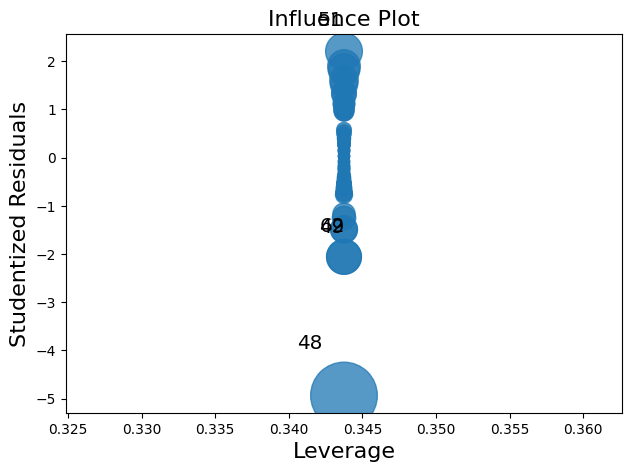

In [21]:
fig = sm.graphics.influence_plot(results_2, criterion="cooks")
fig.tight_layout(pad=1.0)
plt.savefig("img/influence_plot.png")
plt.show()

The influence plot shows two types of information: leverage and studentized residuals:
 - Leverage measures how far an observation is from the center of the data.
 - Studentized residuals measure how far an observation is from the regression line.

### Main Effects Plot

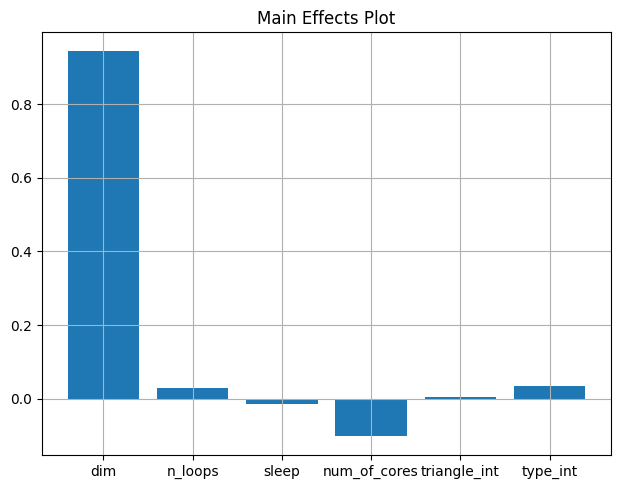

In [22]:
# Separate response and factors
response = df['exec_time']
factors = df.drop('exec_time', axis=1)

# Create linear model
model = sm.OLS(response, factors)
results = model.fit()

# Create main effects plot
fig, ax = plt.subplots()
fig.tight_layout(pad=1.0)
ax.bar(factors.columns, results.params)
ax.set_title('Main Effects Plot')
ax.grid()
plt.show()

 => the higher dimension, the higher computational time. More cores in CPU -> lower computational time.

 This graph shows that prior intuitive interpretation of selected variables was correct.

### IA Plot

In [23]:
from statsmodels.graphics.factorplots import interaction_plot

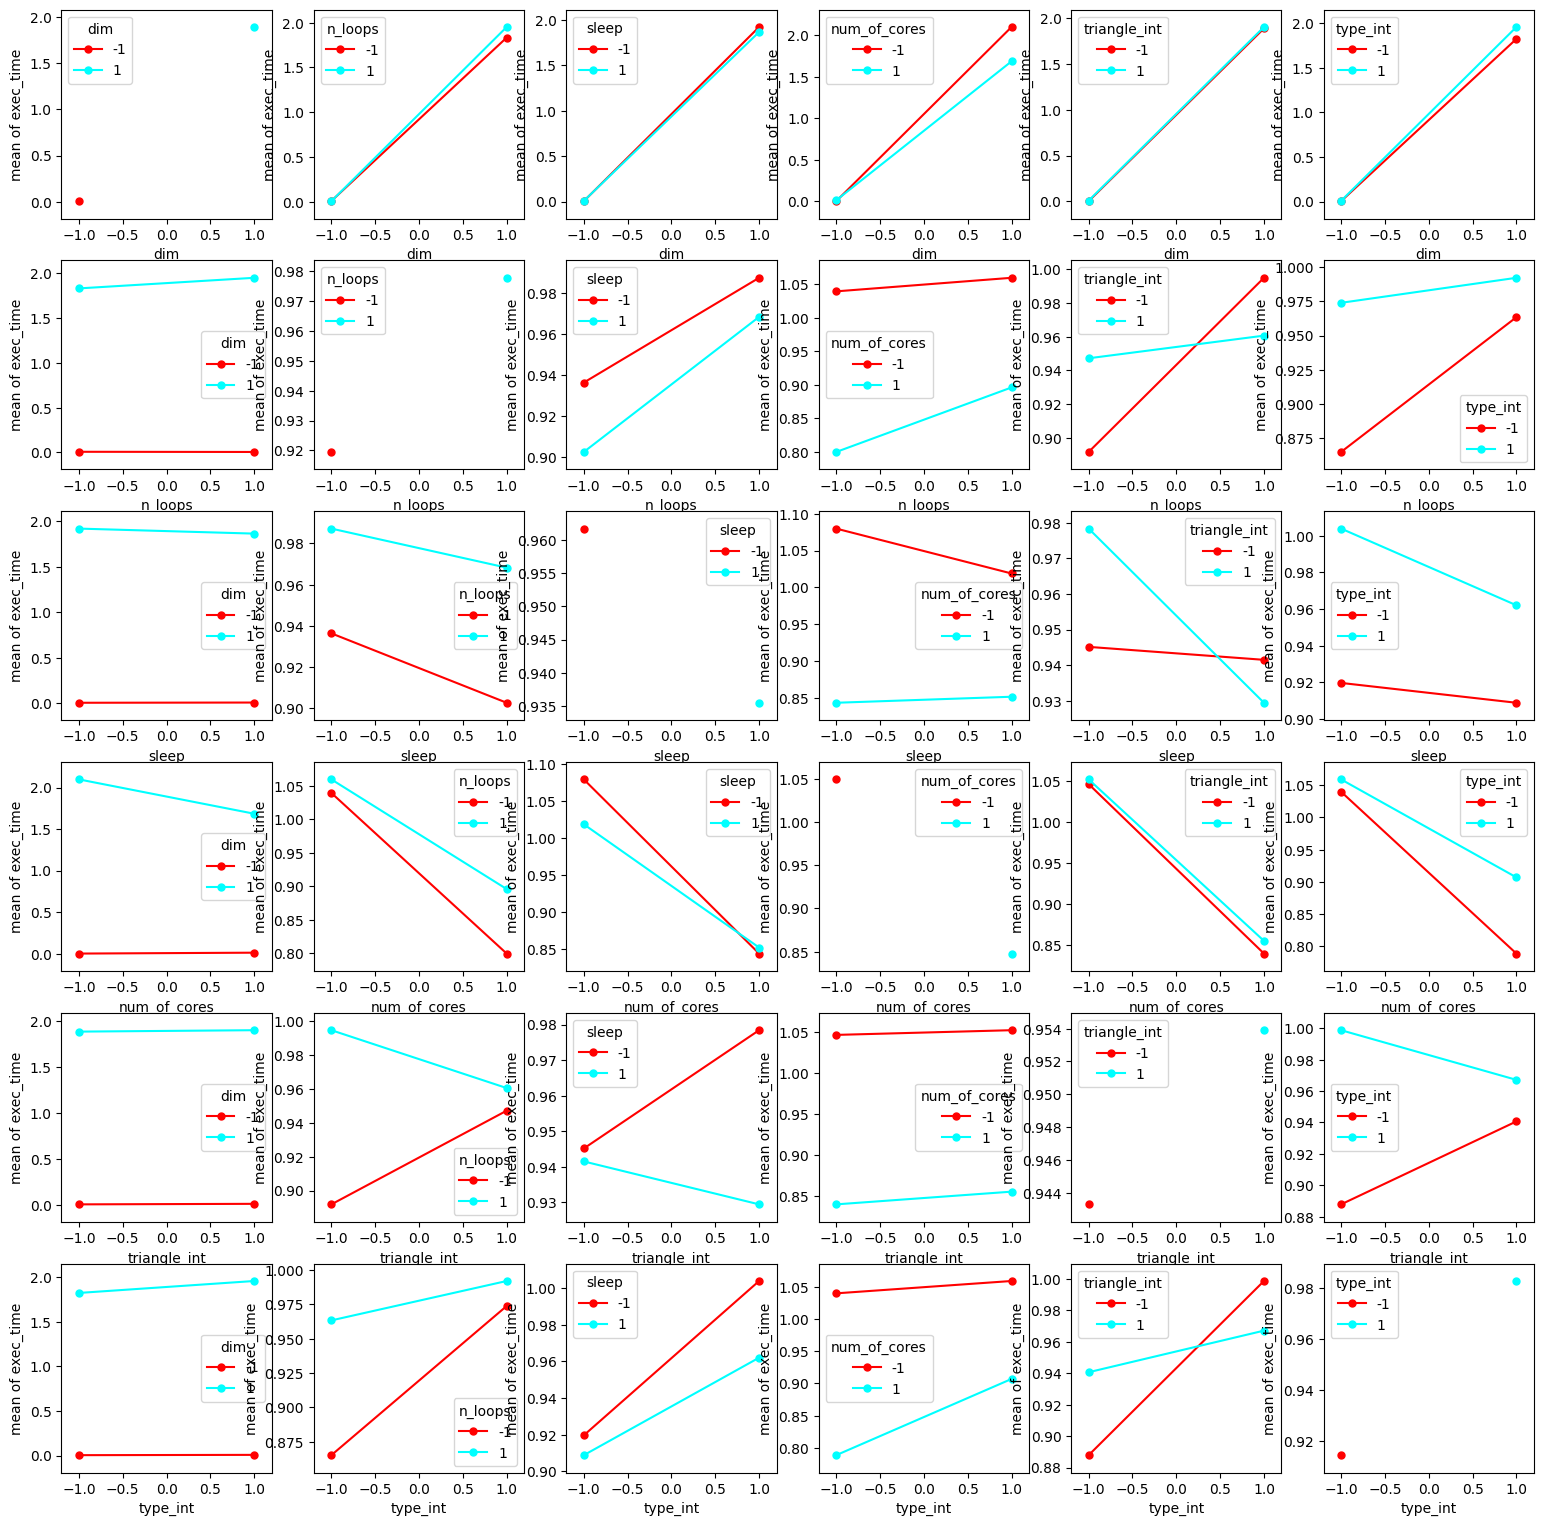

In [24]:
plt.figure(figsize=(19,19))
fig.tight_layout(pad=1.0)
i = 1
for coli in [df.dim, df.n_loops, df.sleep, df.num_of_cores, df.triangle_int , df.type_int]:
    for colj in [df.dim, df.n_loops, df.sleep, df.num_of_cores, df.triangle_int , df.type_int]:
        ax = plt.subplot(6,6,i)
        interaction_plot(x=coli, trace=colj, response=df.exec_time, ms=10, ax=ax)
        i = i + 1
plt.savefig("img/IAPlot_new_data.png", dpi=400)
plt.show()

This interaction plot shows interactions between variables. On each subfigure: x-axis represents one of variables, y-axis always represents response variable (execution time). \
On most subfigures trends of lines are the same (expected).

Most unexpected subfigure(s): **5th row, 2nd column**. It tells that
 - when the computation of `det` is performed *many times in a row*, than det(triangular_mtx) **is computed faster then** det(regular_mtx)
 - when the computation of `det` is performed a *few times*, than det(triangular_mtx) **takes more time** then det(regular_mtx)

Similar inconsistency with 3rd column and 6th column in the same row.

Possible explanation:
 - influenced by some hidden variable that was not taken into account
 - effect is random (for example based on some inicialization...)
 - ???



### Box Plots

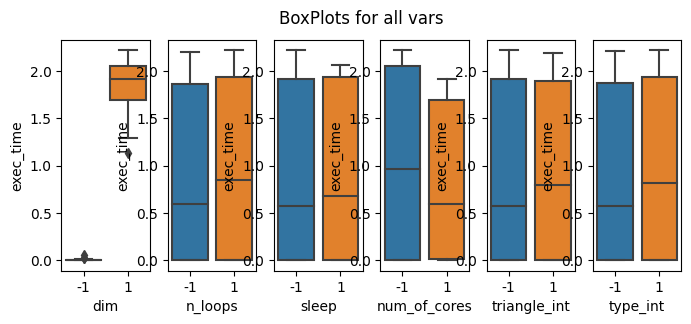

In [25]:
plt.figure(figsize=(8,3))
# 	exec_time 	dim 	n_loops 	sleep 	num_of_cores 	triangle_int 	type_int
plt.subplot(161)
sbn.boxplot( y=df.exec_time, x=df.dim)
plt.subplot(162)
sbn.boxplot( y=df.exec_time, x=df.n_loops)
plt.subplot(163)
sbn.boxplot( y=df.exec_time, x=df.sleep)
plt.subplot(164)
sbn.boxplot( y=df.exec_time, x=df.num_of_cores)
plt.subplot(165)
sbn.boxplot( y=df.exec_time, x=df.triangle_int)
plt.subplot(166)
sbn.boxplot( y=df.exec_time, x=df.type_int)
plt.suptitle("BoxPlots for all vars")
plt.savefig('img/boxplots_new.png', dpi=400)
plt.show()

The boxplot is unsatisfying: it seems `dim` is the only very significant factor that should be taken into account.
Other factors have **promising tendency** (follow median lines), but the errors are too high (it would not be possible to differentiate).

### PairPlot

In [26]:
#sbn.pairplot(df, hue = 'exec_time')
#plt.savefig('img/pairplot.png', dpi=400)
#plt.show()

..commented because it's useless for factor analysis.

## 5. Perform an analysis of variance and find a valid model for the experiment.

### Model of order 2:
all up to 2nd order interactions:

In [27]:
# Fitted model of 2nd order:
print(results_2.summary())

# Print the ANOVA table
print(sm.stats.anova_lm(results_2, typ=2))

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     305.3
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           2.90e-39
Time:                        01:02:18   Log-Likelihood:                 72.842
No. Observations:                  64   AIC:                            -101.7
Df Residuals:                      42   BIC:                            -54.19
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

I will consider every line that has p-value smaller than 0.06, i.e smaller than 6e-02.

In [28]:
6e-02

0.06

In [29]:
anova_table_2 = sm.stats.anova_lm(results_2, typ=2)
anova_table_2.columns
anova_table_2['PR(>F)'] = anova_table_2['PR(>F)'].astype(np.float64)

In [30]:
anova_table_2 =  anova_table_2[anova_table_2['PR(>F)'] < 6e-02]
anova_table_2

,sum_sq,df,F,PR(>F)
dim,56.892626,1.0,6211.317817,2.877675e-47
type_int,0.075452,1.0,8.237571,6.399378e-03
n_loops,0.054177,1.0,5.914871,1.935663e-02
num_of_cores,0.649429,1.0,70.902189,1.460719e-10
dim:type_int,0.068309,1.0,7.457741,9.194061e-03
dim:n_loops,0.058097,1.0,6.342777,1.568270e-02
dim:num_of_cores,0.719648,1.0,78.568364,3.613480e-11
type_int:num_of_cores,0.039245,1.0,4.284629,4.464478e-02


### Reduced model:

In [31]:
formula_chosen = 'exec_time ~ dim + n_loops + type_int + num_of_cores + \
                    + dim:type_int + dim:n_loops + dim:num_of_cores + type_int:num_of_cores'
model_chosen = ols(formula_chosen, data=df)
results_chosen = model_chosen.fit()
print(results_chosen.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     728.2
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           6.60e-53
Time:                        01:02:30   Log-Likelihood:                 61.239
No. Observations:                  64   AIC:                            -104.5
Df Residuals:                      55   BIC:                            -85.05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.94

### ANOVA table of reduced model:

In [32]:
# Print the ANOVA table
print(sm.stats.anova_lm(results_chosen, typ=2))

                          sum_sq    df            F        PR(>F)
dim                    56.892626   1.0  5660.198539  3.744753e-57
n_loops                 0.054177   1.0     5.390055  2.398313e-02
type_int                0.075452   1.0     7.506666  8.271602e-03
num_of_cores            0.649429   1.0    64.611163  7.559633e-11
dim:type_int            0.068309   1.0     6.796028  1.173545e-02
dim:n_loops             0.058097   1.0     5.779994  1.960540e-02
dim:num_of_cores        0.719648   1.0    71.597132  1.553073e-11
type_int:num_of_cores   0.039245   1.0     3.904461  5.318292e-02
Residual                0.552824  55.0          NaN           NaN


At this point, we have build&chosen a model using dataset where each variable has only two possible values.

## 6. If feasible, incorporate measurements at the 'center points' of the numerical variables and analyze their effects.

Considered center points:

 - dim (added dim = 2550: between 100 and 5000)
 - num_of_cores (added num_of_cores = 4: not between 2 and 8, but close)
 - sleep (added sleep = 0.15: between 0 and 0.3 sek)

In [33]:
(5000+100)/2

2550.0

In [34]:
3*2*2*3*3*2

216

In [35]:
#df_cp.describe(include='all')

In [36]:
df_cp = df_cp.drop('sparse', axis=1)
df_cp = df_cp.drop('cpu_info', axis=1)
df_cp = df_cp.drop('curr_time', axis=1)
df_cp = df_cp.drop('env', axis=1)
df_cp = df_cp.drop('CPU', axis=1)
df_cp = df_cp.drop('Unnamed: 0', axis=1)

df_cp.describe()

,exec_time,dim,n_loops,sleep,num_of_cores
count,216.000000,216.000000,216.000000,216.000000,216.000000
mean,0.669867,2550.000000,6.000000,0.150000,4.666667
std,0.767553,2005.063358,3.006969,0.122759,2.500233
min,0.000154,100.000000,3.000000,0.000000,2.000000
25%,0.002985,100.000000,3.000000,0.000000,2.000000
50%,0.289464,2550.000000,6.000000,0.150000,4.000000
75%,1.247435,5000.000000,9.000000,0.300000,8.000000
max,2.221667,5000.000000,9.000000,0.300000,8.000000


In [37]:
print("Original DataFrame:")
print(df_cp)

df_cp = factorize(df_cp, 'dim')
df_cp = factorize(df_cp, 'n_loops')
df_cp = factorize(df_cp, 'sleep')
df_cp = factorize(df_cp, 'num_of_cores')

df_cp['triangle_int'] = df_cp['triangle'].astype(int) # bools to int
df_cp = factorize(df_cp, 'triangle_int')
df_cp = df_cp.drop('triangle', axis=1)

df_cp['type_int'] = df_cp['type'].astype(int) # bools to int
df_cp = factorize(df_cp, 'type_int')
df_cp = df_cp.drop('type', axis=1)

print("\nDataFrame after factorization:")
print(df_cp)

Original DataFrame:
     exec_time   dim   type  n_loops  sleep  triangle  num_of_cores
0     0.000311   100   True        3   0.00     False             2
1     0.000494   100   True        3   0.15     False             2
2     0.000739   100   True        3   0.30     False             2
3     0.000281   100   True        9   0.00     False             2
4     0.000493   100   True        9   0.15     False             2
..         ...   ...    ...      ...    ...       ...           ...
211   1.735943  5000  False        3   0.15      True             8
212   1.583346  5000  False        3   0.30      True             8
213   1.673374  5000  False        9   0.00      True             8
214   1.654428  5000  False        9   0.15      True             8
215   1.851412  5000  False        9   0.30      True             8

[216 rows x 7 columns]

DataFrame after factorization:
     exec_time  dim  n_loops  sleep  num_of_cores  triangle_int  type_int
0     0.000311   -1       -1     -

In [38]:
#print(df_cp.to_string(max_rows=None))

In [39]:
df_cp.to_csv(f'df_cp_testing.csv', sep=';', index=False)

### Model of order 2 on centerpoints:

In [40]:
formula_2_cp = 'exec_time ~ (dim+triangle_int+type_int+n_loops+sleep+num_of_cores)**2'
model_2_cp = ols(formula_2_cp, data=df_cp)
results_2_cp = model_2_cp.fit()
#print(results_2_cp.summary())

ANOVA table for level 6e-02:  (really bad)

In [41]:
anova_table_2_cp = sm.stats.anova_lm(results_2_cp, typ=2)
anova_table_2_cp.columns
anova_table_2_cp['PR(>F)'] = anova_table_2_cp['PR(>F)'].astype(np.float64)

anova_table_2_cp =  anova_table_2_cp[anova_table_2_cp['PR(>F)'] < 6e-02]
anova_table_2_cp

,sum_sq,df,F,PR(>F)
dim,101.428119,1.0,820.904256,1.248991e-71
dim:num_of_cores,0.963810,1.0,7.800553,5.746302e-03


ANOVA table for level 6e-01:

In [42]:
anova_table_2_cp = sm.stats.anova_lm(results_2_cp, typ=2)
anova_table_2_cp.columns
anova_table_2_cp['PR(>F)'] = anova_table_2_cp['PR(>F)'].astype(np.float64)
anova_table_2_cp =  anova_table_2_cp[anova_table_2_cp['PR(>F)'] < 6e-01]
anova_table_2_cp

,sum_sq,df,F,PR(>F)
dim,101.428119,1.0,820.904256,1.248991e-71
num_of_cores,0.116916,1.0,0.946256,3.318854e-01
dim:num_of_cores,0.963810,1.0,7.800553,5.746302e-03
triangle_int:type_int,0.047429,1.0,0.383866,5.362683e-01
sleep:num_of_cores,0.034172,1.0,0.276569,5.995593e-01


It does not look good.
**But if we plot centerploints:**

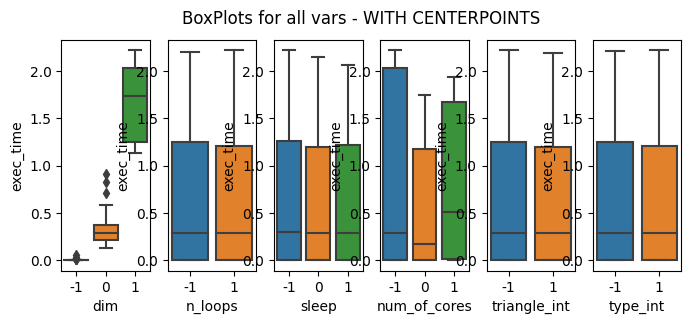

In [43]:
fig = plt.figure(figsize=(8,3))
fig.tight_layout(pad=1.0)
# 	exec_time 	dim 	n_loops 	sleep 	num_of_cores 	triangle_int 	type_int
plt.subplot(161)
sbn.boxplot( y=df_cp.exec_time, x=df_cp.dim)
plt.subplot(162)
sbn.boxplot( y=df_cp.exec_time, x=df_cp.n_loops)
plt.subplot(163)
sbn.boxplot( y=df_cp.exec_time, x=df_cp.sleep)
plt.subplot(164)
sbn.boxplot( y=df_cp.exec_time, x=df_cp.num_of_cores)
plt.subplot(165)
sbn.boxplot( y=df_cp.exec_time, x=df_cp.triangle_int)
plt.subplot(166)
sbn.boxplot( y=df_cp.exec_time, x=df_cp.type_int)
plt.suptitle("BoxPlots for all vars - WITH CENTERPOINTS")
plt.savefig('img/boxplots_new_cp.png', dpi=400)
plt.show()

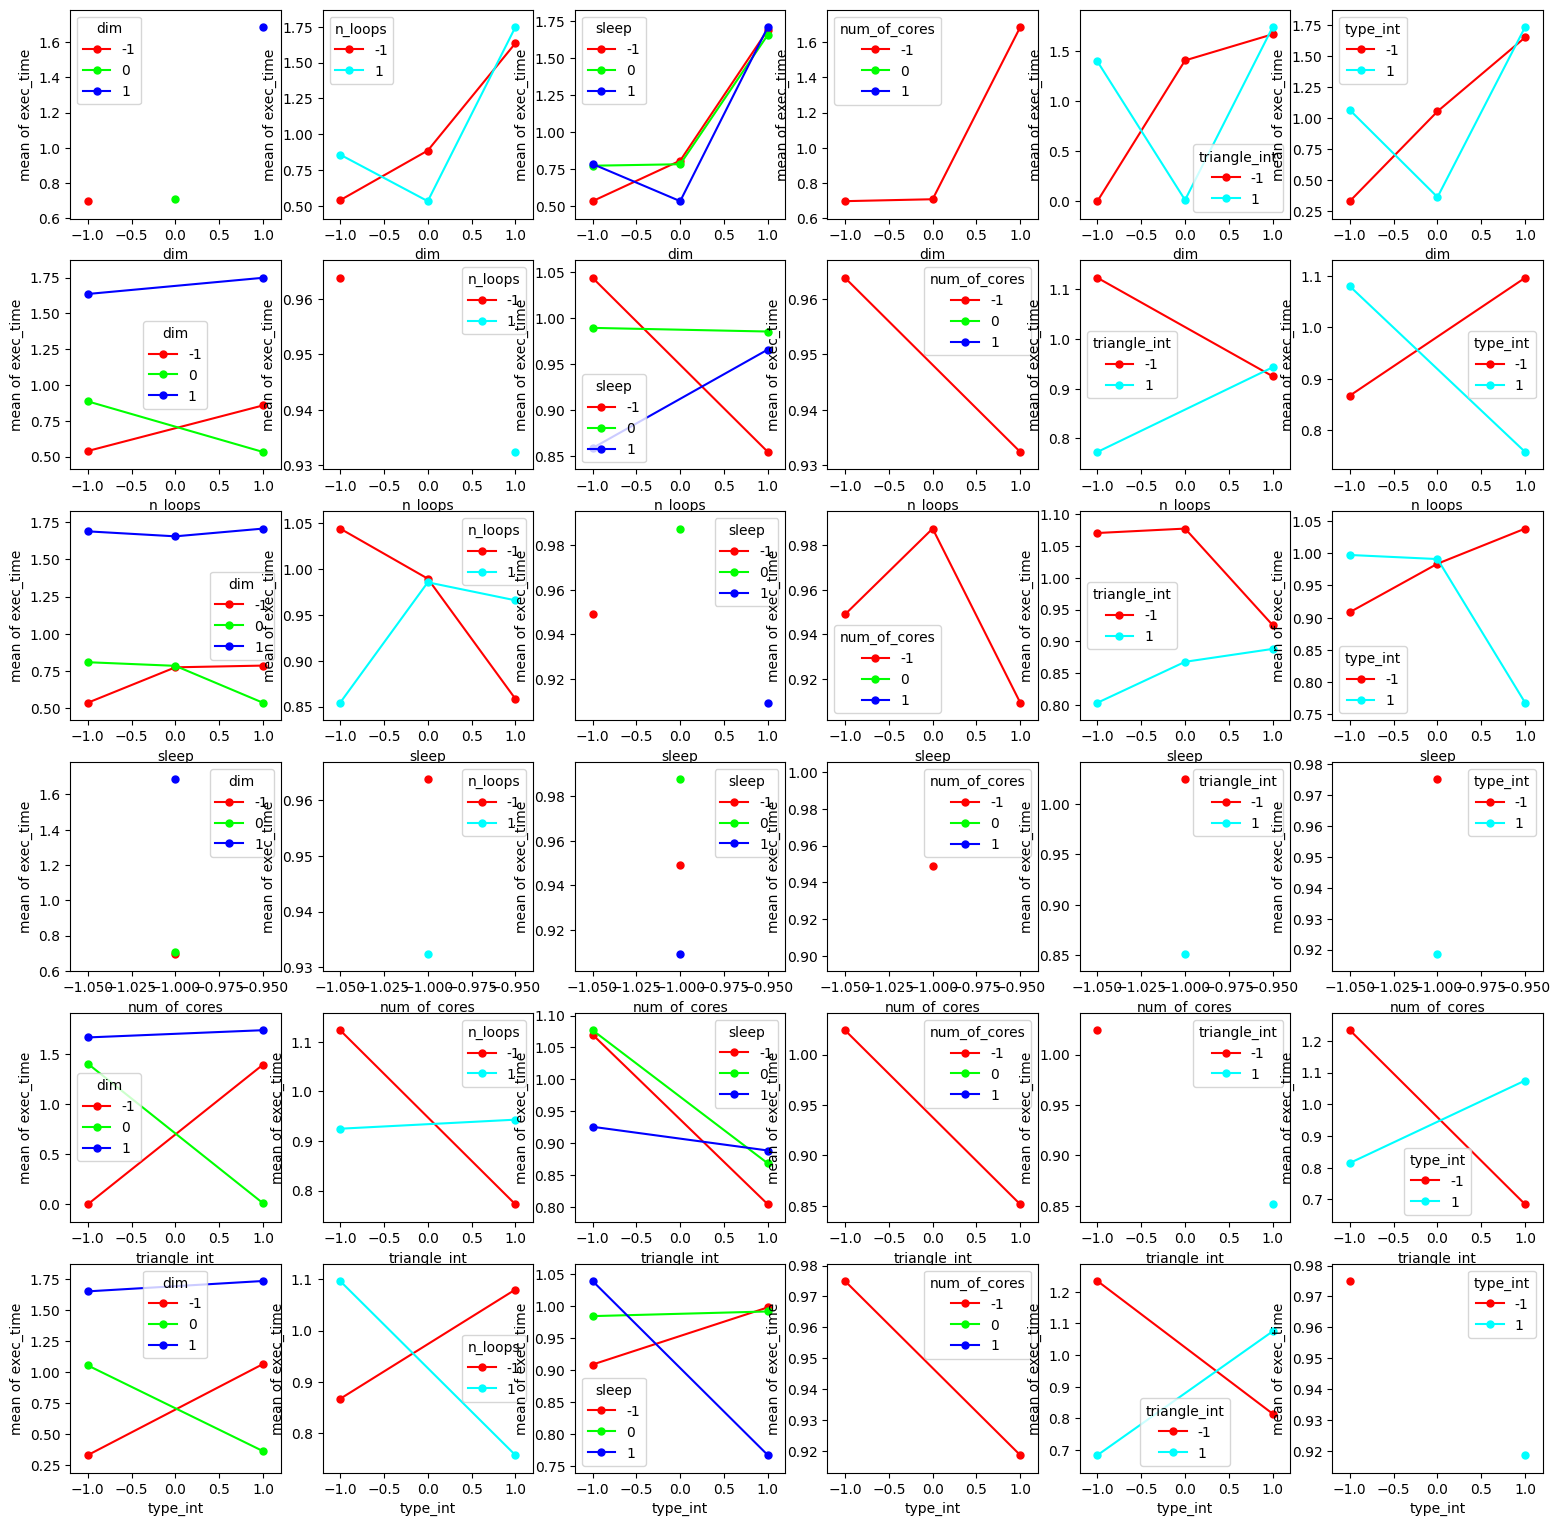

In [44]:
plt.figure(figsize=(19,19))
plt.tight_layout(pad=1.0)
i = 1
for coli in [df_cp.dim, df_cp.n_loops, df_cp.sleep, df_cp.num_of_cores, df_cp.triangle_int , df_cp.type_int]:
    for colj in [df_cp.dim, df_cp.n_loops, df_cp.sleep, df_cp.num_of_cores, df_cp.triangle_int , df_cp.type_int]:
        ax = plt.subplot(6,6,i)
        interaction_plot(x=coli, trace=colj, response=df.exec_time, ms=10, ax=ax)
        i = i + 1
plt.savefig("img/IAPlot_new_data_cp.png", dpi=400)
plt.show()

...and here the reason is clear: adding centerpoints completely destroyed most of the dependencies in the dataset.

### Conclusion to centerpoints:

Adding centerpoints made the model worse. Possible explanations:
 - most of considered variables (except `dim` and `num_of_cores`) are insignificant in this task -> adding centerpoints means adding noise and increasing intervals of prediction (cf. boxplots in this section and previous section)
 - precision of measurements is below the influence of the variables on execution time (they do affect resulting time - see medians on the first boxplot - but it is not possible to recognize via such experimental setup)
 - measurmeent was affected with factors not considered here as a variable: **different OS** (Linux vs. Windows: Linux powered machine might be faster than more modern one running Windows), slightly **different versions of Python3** (3.12.1 vs. 3.11)...

## 7. Construct a regression model using the coded quantitative variables and any significant factor variables.

### Model suggested using centerpoints:

In [45]:
formula_chosen_cp = 'exec_time ~ dim + num_of_cores + dim:num_of_cores'
model_chosen_cp = ols(formula_chosen_cp, data=df_cp)
results_chosen_cp = model_chosen_cp.fit()
print(results_chosen_cp.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     299.9
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           5.50e-76
Time:                        01:03:21   Log-Likelihood:                -69.889
No. Observations:                 216   AIC:                             147.8
Df Residuals:                     212   BIC:                             161.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6699      0.023  

### Model suggested without centerpoints:

In [46]:
formula_chosen = 'exec_time ~ dim + n_loops + type_int + num_of_cores + \
                    + dim:type_int + dim:n_loops + dim:num_of_cores + type_int:num_of_cores'
model_chosen = ols(formula_chosen, data=df)
results_chosen = model_chosen.fit()
print(results_chosen.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     728.2
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           6.60e-53
Time:                        01:03:23   Log-Likelihood:                 61.239
No. Observations:                  64   AIC:                            -104.5
Df Residuals:                      55   BIC:                            -85.05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.94

**Choice of model:** from now on we will stick with this one above. \
**Reasons:**
 - explainable
 - does not violate too much assumptions (see below)
 - has slightly better statistics than centerpointed one
 - both models (`model_chosen_cp` and `model_chosen`) perform on both centerpointed dataset (`df_cp`) and non-centerpointed dataset (`df`) very similarly
 - statistically - only dependence on `dim` can be really proved. Personal hypothesis is that the rest of variables can be significant too (`num_of_cores` definitely), but it would require more experiments performed in more equal starting conditions (isolated cores, same OS, same amount of allocated RAM, more measurements to take median from, ...)

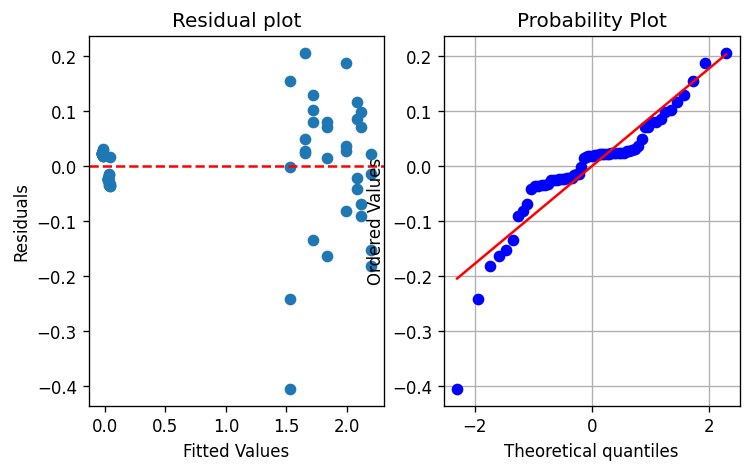

In [47]:
from scipy import stats
plt.figure(figsize=(7,4), dpi=120)
plt.subplot(1,2,1)
plt.scatter(results_chosen.fittedvalues, results_chosen.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title("Residual plot")
plt.axhline(y=0, color='r', linestyle='--')
ax = plt.subplot(1,2,2)
stats.probplot(results_chosen.resid, dist="norm", plot = ax)
plt.grid()

plt.savefig("residuals_of_OLS.png", dpi=300)
plt.show()

In [48]:
# White test (for heteroscedasticity)
from statsmodels.stats.diagnostic import het_white

print(f"H0: variance of error in OLS model is constant.")
white_test_statistic, white_p_value, _, _ = het_white(results_chosen.resid, results_chosen.model.exog)
print(f'White Test Statistic: {white_test_statistic}, p-value: {white_p_value}')

alpha = 0.01  # significance level
if white_p_value < alpha:
    # we dont have enough evidence to accept H_0
    print("Reject H_0 (Have to accept H_1). ")
else:
    # significant evidence to reject H_0, i.e. to accept H_1
    print("Can't reject H_0 (Have to accept H_0). ")

H0: variance of error in OLS model is constant.
White Test Statistic: 26.50278131111226, p-value: 0.03305855333875074
Can't reject H_0 (Have to accept H_0). 


In [49]:
# Normality of residuals - Shapiro-Wilk test
#  (can be important especially in case of small sample size)
print(f"H0: sample (residuals) came from normal distribution.")
from scipy.stats import shapiro
stat, p_value = shapiro(results_chosen.resid)
print(f'Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}')

alpha = 0.01  # significance level
if p_value < alpha:
    # we dont have enough evidence to accept H_0
    print("Reject H_0 (Have to accept H_1). ")
else:
    # significant evidence to reject H_0, i.e. to accept H_1
    print("Can't reject H_0 (Have to accept H_0). ")

H0: sample (residuals) came from normal distribution.
Shapiro-Wilk Test: Statistic=0.8740754723548889, p-value=9.614254850021098e-06
Reject H_0 (Have to accept H_1). 


In [50]:
# VIF
# =is a measure that quantifies the extent of multicollinearity in a set of predictor variables within a regression model.
# Multicollinearity occurs when two or more independent variables in a model are highly correlated,
# making it difficult to isolate the individual effect of each variable on the dependent variable.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Variable"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
#print(vif)
vif

,Variable,VIF
0,exec_time,1.977445
1,dim,1.964025
2,n_loops,1.000918
3,sleep,1.000188
4,num_of_cores,1.011004
5,triangle_int,1.000030
6,type_int,1.001279


## 8. For two chosen numerical variables, create a contour plot to find the optimal values for maximizing bridge strength under the additional condition of 3 layers, minimal width 6cm and 4 folds.

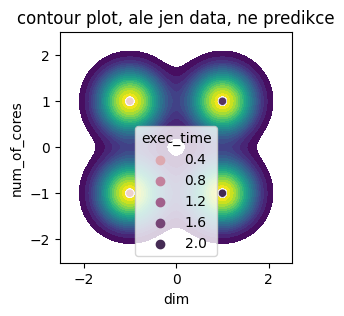

In [51]:
plt.figure(figsize=(3,3))
# Contour plot using seaborn
sbn.kdeplot(data=df, x='dim', y='num_of_cores', fill=True, levels=20, cmap="viridis")

# Scatter plot for data points
sbn.scatterplot(data=df, x='dim', y='num_of_cores', hue='exec_time', color='red') #palette='viridis', marker='o')
plt.title("contour plot, ale jen data, ne predikce")
# Show the plot
plt.show()

In [52]:
df8 = df_before_factorization.copy()

# Fit a linear model
X = sm.add_constant(df8[['dim', 'num_of_cores']])
model8 = sm.OLS(df8['exec_time'], X).fit()
print(model8.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1119.
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           8.32e-49
Time:                        01:03:51   Log-Likelihood:                 27.884
No. Observations:                  64   AIC:                            -49.77
Df Residuals:                      61   BIC:                            -43.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1352      0.044      3.059   

50.0 7500.0 1.8 8.8


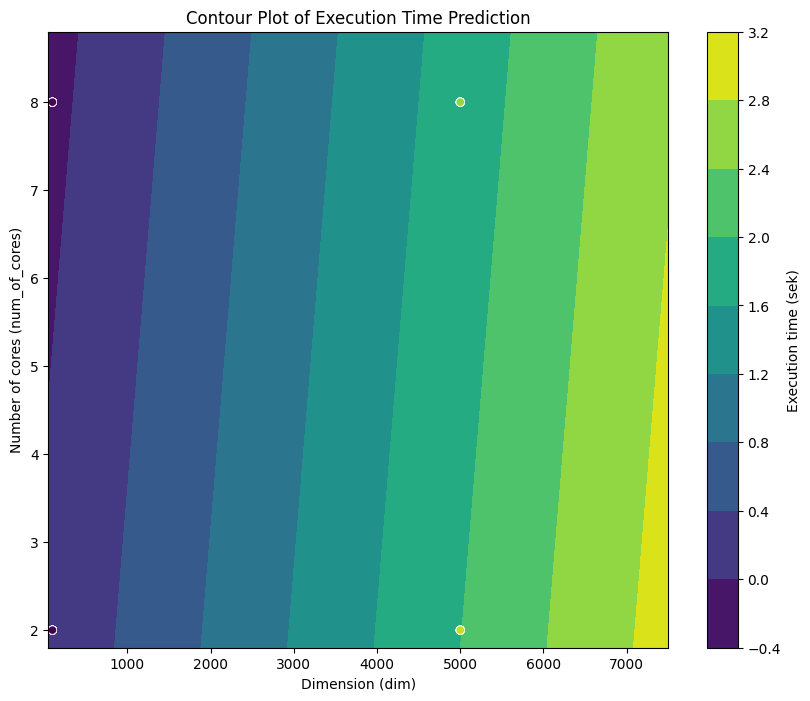

In [53]:
dim_min = df8['dim'].min() - 0.5 * df8['dim'].min()
dim_max = df8['dim'].max() + 0.5 * df8['dim'].max()
cores_min = df8['num_of_cores'].min() - 0.1 * df8['num_of_cores'].min()
cores_max = df8['num_of_cores'].max() + 0.1 * df8['num_of_cores'].max()
print(f"{dim_min} {dim_max} {cores_min} {cores_max}")
dim_range = np.linspace(dim_min, dim_max, 100)
num_of_cores_range = np.linspace(cores_min, cores_max, 100)

dim_grid, num_of_cores_grid = np.meshgrid(dim_range, num_of_cores_range)
design_matrix = pd.DataFrame({'dim': dim_grid.flatten(), 'num_of_cores': num_of_cores_grid.flatten()})
design_matrix_const = sm.add_constant(design_matrix)

# Predict the exec_time for each combination of dim and num_of_cores
predictions = model8.predict(design_matrix_const)

# Reshape the predictions to match the shape of the grids
predictions = predictions.values.reshape(dim_grid.shape)

# Create the contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(dim_grid, num_of_cores_grid, predictions, cmap='viridis')

# Scatter plot for data points
sbn.scatterplot(data=df8, x='dim', y='num_of_cores', hue='exec_time', palette='viridis', marker='o', legend=False)

plt.colorbar(contour, label='Execution time (sek)')
plt.xlim(dim_min, dim_max)
plt.ylim(cores_min, cores_max)
plt.xlabel('Dimension (dim)')
plt.ylabel('Number of cores (num_of_cores)')
plt.title('Contour Plot of Execution Time Prediction')
plt.show()

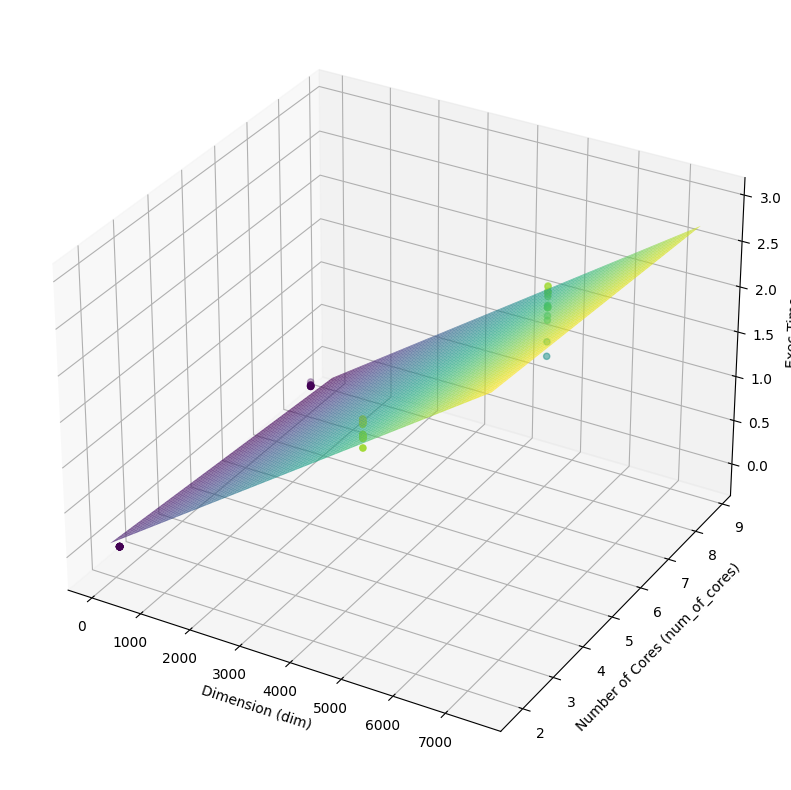

In [54]:
# Plot the hyperplane
# Create the 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for data points
ax.scatter(df8['dim'], df8['num_of_cores'], df8['exec_time'], c=df8['exec_time'], cmap='viridis', marker='o')

ax.plot_surface(dim_grid, num_of_cores_grid, predictions, alpha=0.7, cmap='viridis')

# Set labels and title
ax.set_xlabel('Dimension (dim)')
ax.set_ylabel('Number of Cores (num_of_cores)')
ax.set_zlabel('Exec Time')

# Show the plot
plt.show()

# END.

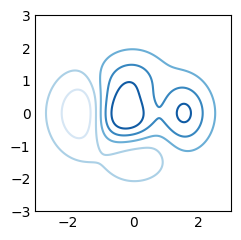

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery-nogrid')

# make data
X, Y = np.meshgrid(np.linspace(-3, 3, 256), np.linspace(-3, 3, 256))
Z = (1 - X/2 + X**5 + Y**3) * np.exp(-X**2 - Y**2)
levels = np.linspace(np.min(Z), np.max(Z), 7)

# plot
fig, ax = plt.subplots()

ax.contour(X, Y, Z, levels=levels)

plt.show()

In [ ]:
4.8e-02

0.048

In [ ]:
4.8e-01

0.48